TODO: code opkuisen

## imports and setting up the environment

In [11]:
import pyannote
import torch
from pathlib import Path
import shutil

# database related imports
from pyannote.database import registry, FileFinder

# training related imports
from pyannote.audio import Pipeline, Model
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.audio.tasks import Segmentation
from pyannote.pipeline import Optimizer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)
from types import MethodType
from torch.optim import Adam

# metrics related imports
from pyannote.metrics.diarization import DiarizationErrorRate

# other
import os

huggingface_token = os.getenv("HUGGINGFACE_TOKEN")


## Data preparation

In [12]:
registry.load_database("database.yml")

protocol = registry.get_protocol("BP.SpeakerDiarization.VlaamseAudio", {"audio":FileFinder()})

for file in protocol.train():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)

for file in protocol.test():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)

for file in protocol.development():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)


/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing BP.SpeakerDiarization.VlaamseAudio protocol by the one defined in '/mnt/c/Users/verho/Documents/School/2024-2025/Bacherlorproef/bp-stemmen-onderscheiden/pyannote/database.yml'.
  warnings.warn(


In [13]:
database = registry.get_database("BP")

database.get_tasks()

['SpeakerDiarization']

## pretrained pyannote pipeline

In [14]:
# get the model from the pipeline

pretrained_pipeline = Pipeline.from_pretrained(Path("./pipeline/config.yaml"))


current error rate of the pipeline (possibly very slow)

In [5]:
metric = DiarizationErrorRate()

for file in protocol.test():
    print(file)
    file["pretrained pipeline"] = pretrained_pipeline(file)
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


Diarization error rate is 9.2% for the pretrained model


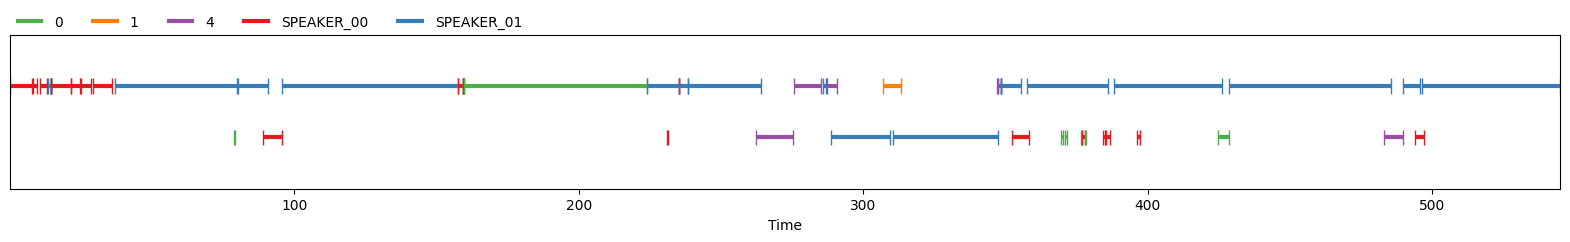

In [6]:
file["pretrained pipeline"]

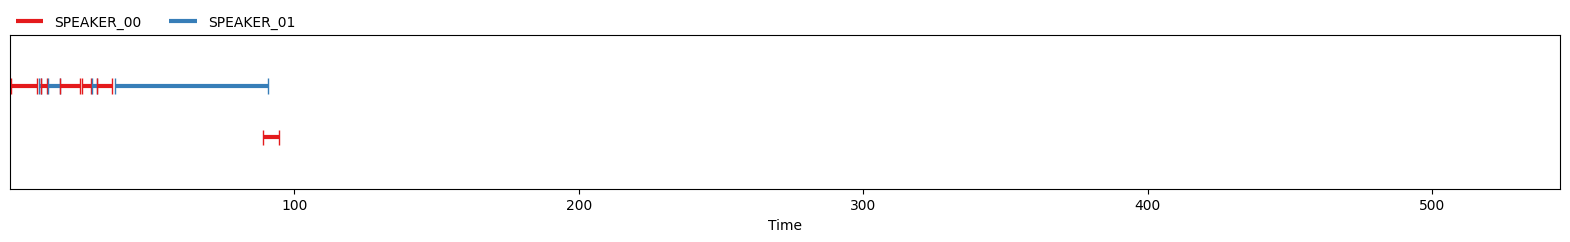

In [7]:
file["annotation"]

## train the model

In [15]:
pretrained_segm_model = Model.from_pretrained("pyannote/segmentation", use_auth_token=huggingface_token)
output_dir = "./models"

task = Segmentation(
    protocol,
    max_num_speakers=5,
    batch_size=32,
    vad_loss="bce"
)

task

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../../../../home/lisa_verhoeyen/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/660b9e20307a2b0cdb400d0f80aadc04a701fc54/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.0+cu126. Bad things might happen unless you revert torch to 1.x.
Protocol BP.SpeakerDiarization.VlaamseAudio does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/tasks/segmentation/speaker_diarization.py:176: UserWarning: `max_num_speakers` has been deprecated in favor of `max_speakers_per_chunk`.
  warnings.warn(


In [17]:
pretrained_segm_model.task = task
pretrained_segm_model.prepare_data()
pretrained_segm_model.setup()

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/core/model.py:229: UserWarning: Model has been trained for a different task. For fine tuning or transfer learning, it is recommended to train task-dependent layers for a few epochs before training the whole model: ['activation', 'classifier'].
  warnings.warn(msg)


In [18]:
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)


In [19]:
pretrained_segm_model.configure_optimizers = MethodType(configure_optimizers, pretrained_segm_model)

In [20]:
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False
)

In [21]:
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False
)

In [22]:
callbacks = [RichProgressBar(), checkpoint, early_stopping]

In [23]:
trainer = pl.Trainer(
    callbacks=callbacks,
    max_epochs=20,
    gradient_clip_val=0.5
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(pretrained_segm_model)

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /mnt/c/Users/verho/Documents/School/2024-2025/Bacherlorproef/bp-stemmen-onderscheiden/pyannote/DiarizationErrorRate exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃      In sizes ┃                           Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ train │ [1, 1, 32000] │                        [1, 60, 115] │
│ 1 │ lstm              │ LSTM             │  1.4 M │ train │  [1, 115, 60] │   [[1, 115, 256], [[8, 1, 128], [8, │
│   │                   │                  │        │       │               │                           1, 128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │ train │             ? │                                   ? │
│ 3 │ classifier        │ Linear           │    645 │ train │ [1, 115, 128] │                         [1, 115, 5] │
│ 4 │ activation        │ Sigmoid          │      0 │ train │   [1, 115, 5] │                         [1, 115, 5] │
│ 5 │ validation_metric │ MetricCollection │      0 │ train │             ? │                                   ? │
└───┴───────────────────┴──────────────────┴────────┴───────┴───────────────┴─────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:123: Your 
`IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), 
`__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of 
training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for 
log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=20` reached.


In [25]:
trained_model = checkpoint.best_model_path


In [26]:
trained_model

'/mnt/c/Users/verho/Documents/School/2024-2025/Bacherlorproef/bp-stemmen-onderscheiden/pyannote/DiarizationErrorRate/epoch=19-v1.ckpt'

In [27]:
# copy the model to a more accessible file
shutil.copy(trained_model, "./models/trained_model.ckpt")

'./models/trained_model.ckpt'

## finetuning
TODO: add finetuning

In [28]:
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
pretrained_hyperparameters

{'segmentation': {'min_duration_off': 0.0},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 12,
  'threshold': 0.7045654963945799}}

In [29]:
pipeline = SpeakerDiarization(
    segmentation=trained_model,
    clustering="OracleClustering"
)

In [30]:
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

In [31]:
optimizer = Optimizer(pipeline)
dev_set = list(protocol.development())

In [32]:
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 50: break

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/pipeline/parameter.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  return trial.suggest_uniform(name, self.low, self.high)
/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/metrics/base.py:325: UserWarning: Cannot compute a reliable confidence interval out of just one file.
  warnings.warn("Cannot compute a reliable confidence interval out of just one file.")


Best segmentation threshold so far: 0.6037871266853381
Best segmentation threshold so far: 0.6037871266853381
Best segmentation threshold so far: 0.6037871266853381
Best segmentation threshold so far: 0.6037871266853381
Best segmentation threshold so far: 0.6037871266853381
Best segmentation threshold so far: 0.6037871266853381
Best segmentation threshold so far: 0.6037871266853381
Best segmentation threshold so far: 0.632218738657234
Best segmentation threshold so far: 0.632218738657234
Best segmentation threshold so far: 0.7018345467553939
Best segmentation threshold so far: 0.7018345467553939
Best segmentation threshold so far: 0.6984711321536758
Best segmentation threshold so far: 0.6984711321536758
Best segmentation threshold so far: 0.6984711321536758
Best segmentation threshold so far: 0.6984711321536758
Best segmentation threshold so far: 0.6984711321536758
Best segmentation threshold so far: 0.6984711321536758
Best segmentation threshold so far: 0.6984711321536758
Best segment

In [33]:
best_segm_threshold = optimizer.best_params["segmentation"]["threshold"]

In [34]:
pipeline = SpeakerDiarization(
    segmentation=trained_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

In [35]:
pipeline.freeze({
    "segmentation": {
        "threshold": best_segm_threshold,
        "min_duration_off": 0.0
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15
    }
})

In [36]:
optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 50: break 

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)
/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/metrics/base.py:325: UserWarning: Cannot compute a reliable confidence interval out of just one file.
  warnings.warn("Cannot compute a reliable confidence interval out of just one file.")
/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/pipeline/parameter.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  return trial.suggest_uniform(name, self.low, self.high)


Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 1.9644042830012804
Best clustering threshold so far: 0.6238198386

In [37]:
best_clust_threshold = optimizer.best_params["clustering"]["threshold"]

In [38]:
finetuned_pipeline = SpeakerDiarization(
    segmentation=trained_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering
)

In [39]:
finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segm_threshold,
        "min_duration_off": 0.0
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clust_threshold
    }
})

## test the new pipeline

In [40]:
metric = DiarizationErrorRate()

for file in protocol.test():
    print(file)
    file["finetuned pipeline"] = finetuned_pipeline(file)
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

/home/lisa_verhoeyen/.local/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


Diarization error rate is 8.5% for the pretrained model


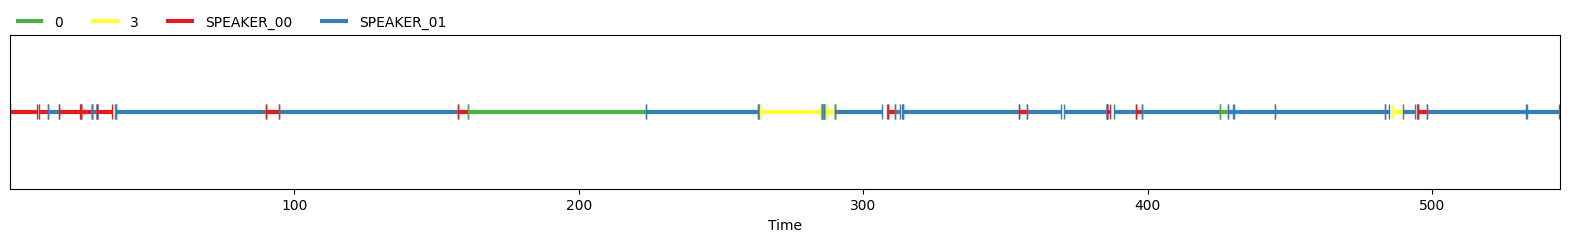

In [41]:
file["finetuned pipeline"]

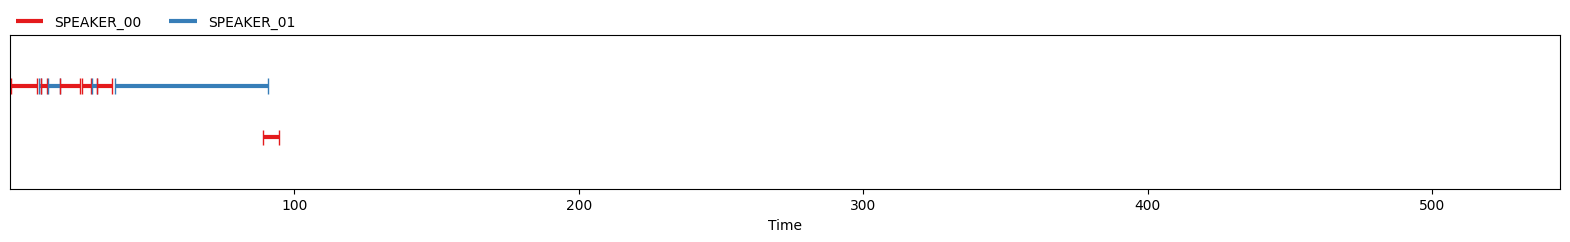

In [42]:
file["annotation"]

In [43]:
finetuned_pipeline.dump_params(Path("./parameters/config.yaml"))

'params:\n  clustering:\n    method: centroid\n    min_cluster_size: 15\n    threshold: 0.6887510457871151\n  segmentation:\n    min_duration_off: 0.0\n    threshold: 0.6888284089567009\n'